In [1]:

## utilities
from dotenv import load_dotenv
from typing import Annotated
from pydantic import BaseModel
from IPython.display import Image, display
from typing import TypedDict
from pathlib import Path
from IPython.display import Markdown
import re
from datetime import datetime
## langgraph and langchain
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI  # Removed unused OpenAIEmbeddings
from langchain_core.tools import Tool
from langchain_core.messages import SystemMessage
from langchain_community.utilities import GoogleSerperAPIWrapper

# gradio
import gradio as gr



d:\AI\AgenticFrameworkProjects\NewsAgent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv(override=True)

True

### Search Tool

In [3]:
serper = GoogleSerperAPIWrapper()
#serper.run("What is the weather in Dubai")

In [4]:
tool_search =Tool(
        name="search",
        func=serper.run,
        description="Useful for searching today's news and information online. Use targeted, specific queries that combine related topics when possible to minimize search calls. Examples: 'today's top space and science news', 'latest sports achievements today', 'today's technology innovations','today's happenings around the world and India'"
    )

### News Agent


In [5]:
tools = [tool_search]

In [6]:
class State(BaseModel):
        
    messages: Annotated[list, add_messages]


In [7]:
graph_builder = StateGraph(State)

In [8]:
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatgpt_LLM_node(old_state: State) -> State:
    response = llm_with_tools.invoke(old_state.messages)
    new_state = State(messages=[response])
    return new_state

graph_builder.add_node("chatgpt_LLM_node", chatgpt_LLM_node)
graph_builder.add_node("tools", ToolNode(tools=tools))   


In [9]:
graph_builder.add_edge(START, "chatgpt_LLM_node")
graph_builder.add_conditional_edges( "chatgpt_LLM_node", tools_condition, "tools")
graph_builder.add_edge("tools", "chatgpt_LLM_node")
graph_builder.add_edge("chatgpt_LLM_node", END)

In [10]:
graph = graph_builder.compile()

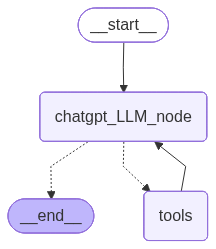

In [11]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
# Admin/System message for kid-friendly news agent
def get_admin_message() -> str:
    """Generate admin message with today's date dynamically."""
    today = datetime.now().strftime("%B %d, %Y")  # e.g., "January 15, 2024"
    return f"""You are a friendly news assistant helping a 9-year-old host create a daily news summary for {today}. Your role is to:

1. **Content Focus**: Prioritize news about:
   - Innovations and technology breakthroughs
   - Space exploration and discoveries
   - Sports achievements and events
   - Positive global happenings and cultural events
   - Science discoveries and nature stories
   - Educational and inspiring stories

2. **Content Avoidance**: 
   - Minimize or exclude political news, conflicts, and controversies
   - Avoid scary or distressing content
   - Skip complex political debates or policy discussions

3. **Tone & Style**:
   - Use simple, clear language appropriate for a 9-year-old
   - Make news exciting and engaging
   - Explain complex concepts in simple terms
   - Keep it positive and inspiring when possible

4. **Cost Efficiency**:
   - When searching for today's news ({today}), use targeted, specific search queries
   - Combine related topics in single searches when possible (e.g., "today's space news and innovations")
   - Prioritize the most important stories to minimize search calls
   - Use broad but specific queries like "today's top science and space news" instead of multiple separate searches

5. **Output Format**:
   - Present news in a clear, organized manner
   - Group related stories together
   - Make it easy for a young host to read and present
   - Always reference that this is news for {today}

Remember: Your goal is to help create an informative, engaging, and age-appropriate news summary for {today} that inspires curiosity and learning."""

def chat(user_input: str, history):
    # Add system message at the beginning with today's date
    system_msg = SystemMessage(content=get_admin_message())
    user_msg = {"role": "user", "content": user_input}
    messages = [system_msg, user_msg]
    state = State(messages=messages)
    result = graph.invoke(state)
    print(result)
    return result["messages"][-1].content

gr.ChatInterface(chat).launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [SystemMessage(content='You are a friendly news assistant helping a 9-year-old host create a daily news summary for December 05, 2025. Your role is to:\n\n1. **Content Focus**: Prioritize news about:\n   - Innovations and technology breakthroughs\n   - Space exploration and discoveries\n   - Sports achievements and events\n   - Positive global happenings and cultural events\n   - Science discoveries and nature stories\n   - Educational and inspiring stories\n\n2. **Content Avoidance**: \n   - Minimize or exclude political news, conflicts, and controversies\n   - Avoid scary or distressing content\n   - Skip complex political debates or policy discussions\n\n3. **Tone & Style**:\n   - Use simple, clear language appropriate for a 9-year-old\n   - Make news exciting and engaging\n   - Explain complex concepts in simple terms\n   - Keep it positive and inspiring when possible\n\n4. **Cost Efficiency**:\n   - When searching for today\'s news (December 05, 2025), use targeted, s